In [ ]:
# Install standard libraries
!pip install torch pandas numpy matplotlib scikit-learn -q
import os

# Clone PatchTST repository
if not os.path.exists('PatchTST'):
    !git clone https://github.com/yuqinie98/PatchTST.git
    print("Cloned PatchTST repository.")
else:
    print("PatchTST repository already exists.")

# Clone HopCPT repository
if not os.path.exists('HopCPT'):
    !git clone https://github.com/ml-jku/HopCPT.git
    print("Cloned HopCPT repository.")
else:
    print("HopCPT repository already exists.")

print("✅ Libraries installed and repositories cloned!")

PatchTST repository already exists.
HopCPT repository already exists.
✅ Libraries installed and repositories cloned!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import os

PROJECT_DIR = "/content/drive/MyDrive/PatchCPT_Project"
if not os.path.exists(PROJECT_DIR):
    os.makedirs(PROJECT_DIR)
    print(f"Created project directory at: {PROJECT_DIR}")
else:
    print(f"Project directory already exists at: {PROJECT_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project directory already exists at: /content/drive/MyDrive/PatchCPT_Project


In [ ]:
# --- Standard Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import sys
from tqdm.auto import tqdm
from typing import Optional

# --- PyTorch Libraries ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# --- Scikit-Learn ---
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# We add the PARENT 'supervised' folder to the path.
sys.path.append('/content/PatchTST/PatchTST_supervised')

try:
    # Now that the parent is on the path, we can import from 'models'
    # and the model itself can successfully import from its sibling 'layers' folder.
    from models.PatchTST import Model as PatchTST
    print("✅ Successfully imported PatchTST (class 'Model').")
except Exception as e:
    print(f"❌ Error importing PatchTST: {e}")
    print("   Please ensure the path '/content/PatchTST/PatchTST_supervised' exists.")

class Hopfield(torch.nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size: Optional[int] = None,
                 output_size: Optional[int] = None,
                 num_heads: int = 8,
                 dropout: float = 0.0,
                 scaling: Optional[float] = None,
                 **kwargs):
        super(Hopfield, self).__init__()
        if hidden_size is None: hidden_size = input_size
        if output_size is None: output_size = input_size
        self.input_size, self.hidden_size, self.output_size = input_size, hidden_size, output_size
        self.num_heads = num_heads
        assert self.hidden_size % self.num_heads == 0, 'hidden_size must be divisible by num_heads.'
        self.head_size = self.hidden_size // self.num_heads
        scaling = scaling if scaling is not None else self.head_size ** (1/4)
        self.scaling = torch.nn.Parameter(torch.tensor([scaling]), requires_grad=False)
        self.W_Q = torch.nn.Linear(in_features=self.input_size, out_features=self.hidden_size, bias=False)
        self.W_K = torch.nn.Linear(in_features=self.input_size, out_features=self.hidden_size, bias=False)
        self.W_V = torch.nn.Linear(in_features=self.input_size, out_features=self.hidden_size, bias=False)
        self.W_O = torch.nn.Linear(in_features=self.hidden_size, out_features=self.output_size, bias=False)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self,
                query: torch.Tensor,
                key: torch.Tensor,
                value: torch.Tensor,
                return_raw_associations: bool = False) -> torch.Tensor:
        batch_size, query_len, _ = query.shape
        key_len, value_len = key.shape[1], value.shape[1]
        assert key_len == value_len, 'key and value must have same sequence length.'
        Q = self.W_Q(query).view(batch_size, query_len, self.num_heads, self.head_size).transpose(1, 2)
        K = self.W_K(key).view(batch_size, key_len, self.num_heads, self.head_size).transpose(1, 2)
        V = self.W_V(value).view(batch_size, value_len, self.num_heads, self.head_size).transpose(1, 2)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scaling
        attn_weights = self.softmax(attn_scores)
        attn_weights = self.dropout(attn_weights)
        output = torch.matmul(attn_weights, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, query_len, self.hidden_size)
        output = self.W_O(output)
        return (output, attn_scores) if return_raw_associations else (output, attn_weights)

print("✅ Hopfield (MHN) class manually defined.")

# --- 4. Device and Seed Setup ---
# We also run the device and seed setup here.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed_value=42):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
print("✅ Device set and seed fixed.")
print("\n--- All Setup Complete ---")

✅ Successfully imported PatchTST (class 'Model').
✅ Hopfield (MHN) class manually defined.
Using device: cuda
✅ Device set and seed fixed.

--- All Setup Complete ---


In [ ]:
import torch
import torch.nn as nn

# --- This is the RevIN class that PatchTST was failing to import ---
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

print("✅ RevIN class defined.")

✅ RevIN class defined.


In [ ]:
import torch
from torch import nn
from typing import Optional

# --- Helper Layers (from layers/PatchTST_layers.py) ---

class TSTiEncoder(nn.Module):
    def __init__(self, c_in, patch_num, patch_len, n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., act="gelu", store_attn=False,
                 key_padding_mask='patch', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 pe='zeros', learn_pe=True, verbose=False, **kwargs):

        super().__init__()

        self.patch_num = patch_num
        self.patch_len = patch_len

        # Patching
        self.patching = nn.Linear(patch_len, d_model)

        # Positional embedding
        if pe == 'zeros':
            self.W_pos = nn.Parameter(torch.zeros(1, patch_num, d_model))
        elif pe == 'sincos':
            self.W_pos = nn.Parameter(torch.zeros(1, patch_num, d_model))
            self.W_pos = self.positional_encoding(patch_num, d_model)
        else:
            raise ValueError(f"pe: {pe} not implemented")

        self.learn_pe = learn_pe
        if learn_pe:
            self.W_pos = nn.Parameter(self.W_pos)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=n_heads,
                dim_feedforward=d_ff,
                dropout=dropout,
                activation=act,
                batch_first=True
            ) for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model) if pre_norm else nn.Identity()

    def forward(self, x) -> torch.Tensor:                                              # x: [B, C, N, P]

        n_vars = x.shape[1]

        # Input encoding
        x = x.permute(0, 1, 3, 2)                                                      # x: [B, C, P, N]
        x = self.patching(x)                                                         # x: [B, C, N, D]

        x = x.reshape(x.shape[0] * x.shape[1], x.shape[2], x.shape[3])                 # x: [B*C, N, D]
        x = self.dropout(x + self.W_pos)                                             # x: [B*C, N, D]

        # Encoder
        x = self.norm(x)
        for layer in self.layers:
            x = layer(x)

        x = x.reshape(-1, n_vars, self.patch_num, x.shape[-1])                        # x: [B, C, N, D]
        x = x.permute(0, 1, 3, 2)                                                      # x: [B, C, D, N]

        return x, None  # Return None for attns


# --- Main Model Class (from models/PatchTST.py) ---

class PatchTST(nn.Module):
    def __init__(self, configs, **kwargs):

        super().__init__()

        # load parameters
        c_in = configs.enc_in
        context_window = configs.seq_len
        target_window = configs.pred_len

        n_layers = configs.e_layers
        n_heads = configs.n_heads
        d_model = configs.d_model
        d_ff = configs.d_ff
        dropout = configs.dropout
        fc_dropout = configs.fc_dropout
        head_dropout = configs.head_dropout

        individual = configs.individual

        patch_len = configs.patch_len
        stride = configs.stride
        padding_patch = configs.padding_patch

        revin = configs.revin
        affine = configs.affine
        subtract_last = configs.subtract_last

        decomposition = configs.decomposition
        kernel_size = configs.kernel_size


        # RevIN
        self.revin = revin
        if self.revin:
            self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)
        else:
            self.revin_layer = nn.Identity()

        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        self.patch_num = int((context_window - patch_len)/stride + 1)
        if padding_patch == 'end': # can be modified to handle more general cases
            self.padding_patch_layer = nn.ReplicationPad1d((0, stride))
            self.patch_num += 1

        # Backbone
        self.backbone = TSTiEncoder(c_in, patch_num=self.patch_num, patch_len=patch_len, n_layers=n_layers,
                                  d_model=d_model, n_heads=n_heads, d_ff=d_ff, attn_dropout=0,
                                  dropout=dropout, act='gelu', res_attention=True, **kwargs)

        # Head
        self.head_nf = d_model * self.patch_num
        self.head = nn.Sequential(
            nn.Flatten(start_dim=-2),
            nn.Linear(self.head_nf, d_model),
            nn.ReLU(),
            nn.Dropout(head_dropout),
            nn.Linear(d_model, target_window)
        )
        self.individual = individual
        if self.individual:
            self.head = nn.ModuleList()
            for i in range(c_in):
                self.head.append(
                    nn.Sequential(
                        nn.Flatten(start_dim=-2),
                        nn.Linear(self.head_nf, d_model),
                        nn.ReLU(),
                        nn.Dropout(head_dropout),
                        nn.Linear(d_model, target_window)
                    )
                )

    def forward(self, x):                                              # x: [B, L, C]

        # RevIN
        x = self.revin_layer(x, 'norm')
        x = x.permute(0, 2, 1)                                         # x: [B, C, L]

        # Patching
        if self.padding_patch == 'end':
            x = self.padding_patch_layer(x)
        x = x.unfold(dimension=2, size=self.patch_len, step=self.stride) # x: [B, C, N, P]
        x = x.permute(0, 1, 3, 2)                                      # x: [B, C, P, N]

        # Backbone
        x, attns = self.backbone(x)                                    # x: [B, C, D, N]
        x = x.permute(0, 1, 3, 2)                                      # x: [B, C, N, D]

        # Head
        if self.individual:
            x_out = torch.zeros(x.shape[0], x.shape[1], self.head[0][3].out_features, device=x.device) # B, C, H
            for i in range(x.shape[1]):
                x_out[:, i, :] = self.head[i](x[:, i, :, :])
            x = x_out
            x = x.permute(0, 2, 1)                                   # x: [B, H, C]
        else:
            x = self.head(x)                                         # x: [B, C, H]
            x = x.permute(0, 2, 1)                                   # x: [B, H, C]

        # Denorm
        x = self.revin_layer(x, 'denorm')
        return x

print("✅ PatchTST (local class) defined.")

✅ PatchTST (local class) defined.


#Section 2

In [ ]:
import pandas as pd
import os

PROJECT_DIR = "/content/drive/MyDrive/PatchCPT_Project"
DATA_PATH = os.path.join(PROJECT_DIR, "ETTh1.csv")

# Download the data if it doesn't exist
if not os.path.exists(DATA_PATH):
    print("Downloading ETTh1.csv data...")
    # This URL points to the raw CSV file in the dataset's GitHub repo
    !wget -P {PROJECT_DIR} https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv
    print(f"Data saved to {DATA_PATH}")
else:
    print(f"Data already exists at {DATA_PATH}")

# Load the dataframe to check
df = pd.read_csv(DATA_PATH)
print("\nData loaded. Head:")
print(df.head())

Data already exists at /content/drive/MyDrive/PatchCPT_Project/ETTh1.csv

Data loaded. Head:
                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


In [ ]:
# --- Global Model & Data Configuration ---

class Config:
    def __init__(self):
        # --- Data Parameters ---
        self.dataset = 'ETTh1'
        self.data_path = DATA_PATH
        self.target_col = 'OT'  # 'OT' (Oil Temperature) is the target for ETTh1
        self.n_features = 7     # ETTh1 has 7 features (OT + 6 covariates)

        # --- Windowing Parameters ---
        # Look-back window (how much history to use)
        self.seq_len = 96  # 96 hours (4 days)
        # Prediction window (how far to forecast)
        self.pred_len = 96 # 96 hours (4 days)

        # --- PatchTST Model Parameters ---
        self.patch_len = 16   # Length of each patch
        self.stride = 8       # Stride between patches
        self.d_model = 128    # Model dimension
        self.n_heads = 8      # Number of attention heads
        self.n_layers = 3     # Number of encoder layers
        self.dropout = 0.1

        # --- Training Parameters ---
        self.batch_size = 32
        self.n_epochs_patchtst = 20  # Total epochs for PatchTST
        self.n_epochs_hopcpt = 20    # Total epochs for HopCPT module
        self.learning_rate = 0.0001

        # --- Conformal Prediction Parameters ---
        self.alpha = 0.05  # For 95% prediction intervals (1 - alpha)

        # --- "Smoke Test" Setting ---
        # Set this to True to run on 1000 samples for debugging
        # Set to False to run on the full dataset
        self.smoke_test = False

# Create an instance of the config
config = Config()

# Print the config to verify
import json
print(json.dumps(config.__dict__, indent=2))

{
  "dataset": "ETTh1",
  "data_path": "/content/drive/MyDrive/PatchCPT_Project/ETTh1.csv",
  "target_col": "OT",
  "n_features": 7,
  "seq_len": 96,
  "pred_len": 96,
  "patch_len": 16,
  "stride": 8,
  "d_model": 128,
  "n_heads": 8,
  "n_layers": 3,
  "dropout": 0.1,
  "batch_size": 32,
  "n_epochs_patchtst": 20,
  "n_epochs_hopcpt": 20,
  "learning_rate": 0.0001,
  "alpha": 0.05,
  "smoke_test": false
}


In [ ]:
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

class TimeSeriesWindowDataset(Dataset):
    def __init__(self, data, seq_len, pred_len, scale=True, scaler=None):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.total_len = seq_len + pred_len
        self.scale = scale

        if self.scale:
            if scaler is None:
                # Fit a new scaler
                self.scaler = StandardScaler()
                self.data_scaled = self.scaler.fit_transform(self.data)
            else:
                # Use the provided (already fit) scaler
                self.scaler = scaler
                self.data_scaled = self.scaler.transform(self.data)
        else:
            self.data_scaled = self.data.values

    def __len__(self):
        # This determines the total number of samples we can create
        return len(self.data_scaled) - self.total_len + 1

    def __getitem__(self, index):
        # The input window
        x = self.data_scaled[index : index + self.seq_len]

        # The output (target) window
        y = self.data_scaled[index + self.seq_len : index + self.total_len]

        # Return as tensors
        # We only care about the target column 'OT' for the y
        # But the model in the repo is multivariate, so it predicts all 7 features
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def get_scaler(self):
        return self.scaler

print("✅ TimeSeriesWindowDataset class defined.")

✅ TimeSeriesWindowDataset class defined.


In [ ]:
from torch.utils.data import DataLoader

# --- Load and Split Data ---
df = pd.read_csv(config.data_path, parse_dates=['date'])
df = df.drop('date', axis=1) # Drop the date column, keep only numbers

# The standard ETT split (as used in the paper)
# 60% Train, 20% Validation, 20% Test
total_len = len(df)
train_end = int(total_len * 0.6)
val_end = int(total_len * 0.8)

df_train = df.iloc[:train_end]
df_val = df.iloc[train_end:val_end]
df_test = df.iloc[val_end:]

# --- Apply "Smoke Test" if enabled ---
if config.smoke_test:
    print("🔥🔥🔥 SMOKE TEST ENABLED 🔥🔥🔥")
    # We need enough data to create at least one window
    smoke_len = 1000 + config.seq_len + config.pred_len
    print(f"Using a tiny subset of {smoke_len} rows for debugging.")


    df_train = df_train.iloc[:smoke_len]
    df_val = df_val.iloc[:smoke_len]
    df_test = df_test.iloc[:smoke_len]

print(f"Data shapes (Smoke Test={config.smoke_test}):")
print(f"Train: {df_train.shape}")
print(f"Val:   {df_val.shape}")
print(f"Test:  {df_test.shape}")
print("-" * 30)

# --- Create Datasets ---

# 1. Create and fit scaler on the TRAINING data
train_dataset = TimeSeriesWindowDataset(
    df_train, config.seq_len, config.pred_len, scale=True, scaler=None
)
train_scaler = train_dataset.get_scaler()

# 2. Use the FITTED scaler to transform val and test data
val_dataset = TimeSeriesWindowDataset(
    df_val, config.seq_len, config.pred_len, scale=True, scaler=train_scaler
)
test_dataset = TimeSeriesWindowDataset(
    df_test, config.seq_len, config.pred_len, scale=True, scaler=train_scaler
)

# --- Create DataLoaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,  # Shuffle training data
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False, # No shuffle for validation
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False, # No shuffle for test
    num_workers=2
)

print("\nDataLoaders created.")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# --- Test one batch ---
try:
    x, y = next(iter(train_loader))
    print("\nSuccessfully loaded one batch:")
    print(f"Input batch shape (x):  {x.shape}")
    print(f"Output batch shape (y): {y.shape}")
except Exception as e:
    print(f"\n❌ Error loading batch: {e}")
    print("This might happen if the 'smoke_test' dataset is too small for one batch.")

Data shapes (Smoke Test=False):
Train: (10452, 7)
Val:   (3484, 7)
Test:  (3484, 7)
------------------------------

DataLoaders created.
Number of training batches: 321
Number of validation batches: 103
Number of test batches: 103

Successfully loaded one batch:
Input batch shape (x):  torch.Size([32, 96, 7])
Output batch shape (y): torch.Size([32, 96, 7])


#Section 3

In [ ]:
import torch.optim as optim
import time

# --- 1. Instantiate Model, Optimizer, and Loss ---

# Get the device (defined in Block 1.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configuration from our 'config' object
patchtst_config = {
    # --- Data parameters ---
    'enc_in': config.n_features,
    'c_out': config.n_features,
    'seq_len': config.seq_len,
    'pred_len': config.pred_len,

    # --- Model structure parameters (FIXED) ---
    'e_layers': config.n_layers,
    'n_heads': config.n_heads,
    'd_model': config.d_model,
    'd_ff': config.d_model * 4,
    'dropout': config.dropout,
    'fc_dropout': config.dropout,
    'head_dropout': config.dropout,
    'individual': False,
    'activation': 'gelu',
    'patch_len': config.patch_len,
    'stride': config.stride,

    # --- Other required parameters from the repo (FIXED) ---
    'padding_patch': 'end',
    'revin': True,
    'affine': True,
    'subtract_last': False,
    'decomposition': False,
    'kernel_size': 25,          # <-- ADDED (a default for moving avg, even if not used)
    'task_name': 'long_term_forecast',
    'context_window': config.seq_len,
    'target_window': config.pred_len,
    'label_len': 0,
    'd_k': None,
    'd_v': None,
    'norm': 'BatchNorm',
    'attn_dropout': 0.0,
    'act': 'gelu',
    'key_padding_mask': 'patch',
    'padding_var': None,
    'attn_mask': None,
    'res_attention': True,
    'pre_norm': False,
    'store_attn': False,
    'pe': 'zeros',
    'learn_pe': True,
    'pretrain_head': False,
    'head_type': 'flatten',
    'verbose': False
}


# The 'Model' class we imported takes a custom 'config' object as input.
class PatchTSTConfigObject:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

model_config = PatchTSTConfigObject(**patchtst_config)

# Instantiate the model
# The model's __init__ takes 'configs' as the argument
model = PatchTST(model_config).to(device) # <-- Pass the config object

# Initialize Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
criterion = nn.MSELoss()

print(f"PatchTST model instantiated and moved to {device}.")
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# --- 2. Define Helper Functions for Training and Evaluation ---

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in loader:
        # Move data to the device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        # --- Forward pass ---
        y_pred = model(x_batch) # This will just return the forecast

        # Calculate loss (only on the target variable 'OT')
        target_col_index = list(df_train.columns).index(config.target_col)

        loss = criterion(y_pred[..., target_col_index], y_batch[..., target_col_index])

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch) # Just the forecast

            target_col_index = list(df_train.columns).index(config.target_col)
            loss = criterion(y_pred[..., target_col_index], y_batch[..., target_col_index])

            total_loss += loss.item()

    return total_loss / len(loader)

# --- 3. Main Training Loop ---

print("--- Starting PatchTST Training ---")
n_epochs = config.n_epochs_patchtst  #
best_val_loss = float('inf')
model_save_path = os.path.join(PROJECT_DIR, "best_patchtst.pth")

for epoch in range(n_epochs):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)

    end_time = time.time()
    epoch_mins = (end_time - start_time) / 60

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.2f}m')
    print(f'\tTrain Loss: {train_loss:.6f}')
    print(f'\t Val. Loss: {val_loss:.6f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_save_path)
        print(f'\t>> Validation loss decreased. Saving model to {model_save_path}')

print("--- PatchTST Training Complete ---")
print(f"Best validation loss: {best_val_loss:.6f}")
print(f"Model saved to {model_save_path}")

PatchTST model instantiated and moved to cuda.
Total parameters: 807662
--- Starting PatchTST Training ---
Epoch: 01 | Time: 0.09m
	Train Loss: 0.188988
	 Val. Loss: 0.085356
	>> Validation loss decreased. Saving model to /content/drive/MyDrive/PatchCPT_Project/best_patchtst.pth
Epoch: 02 | Time: 0.08m
	Train Loss: 0.174176
	 Val. Loss: 0.083269
	>> Validation loss decreased. Saving model to /content/drive/MyDrive/PatchCPT_Project/best_patchtst.pth
Epoch: 03 | Time: 0.09m
	Train Loss: 0.168616
	 Val. Loss: 0.082969
	>> Validation loss decreased. Saving model to /content/drive/MyDrive/PatchCPT_Project/best_patchtst.pth
Epoch: 04 | Time: 0.08m
	Train Loss: 0.161818
	 Val. Loss: 0.088625
Epoch: 05 | Time: 0.09m
	Train Loss: 0.153815
	 Val. Loss: 0.087230
Epoch: 06 | Time: 0.09m
	Train Loss: 0.144002
	 Val. Loss: 0.087446
Epoch: 07 | Time: 0.08m
	Train Loss: 0.134753
	 Val. Loss: 0.089070
Epoch: 08 | Time: 0.09m
	Train Loss: 0.124537
	 Val. Loss: 0.092123
Epoch: 09 | Time: 0.08m
	Train Los

# Section 4

In [ ]:
import torch
import sys

# This ensures the model can find its 'layers' dependency
sys.path.append('/content/PatchTST/PatchTST_supervised')

# --- 2. Define the PatchCPT Backbone ---
# We inherit from the 'PatchTST' class

PatchTST_base_class = PatchTST

class PatchCPT_Backbone(PatchTST_base_class):
    def __init__(self, configs):
        # We call the base class init directly.
        PatchTST_base_class.__init__(self, configs)

    def forward(self, x_enc):
        # This is our override of the forward pass to capture 'z'.

        # 1. RevIN
        x = self.revin_layer(x_enc, 'norm')
        x = x.permute(0, 2, 1)                                         # x: [B, C, L]

        # 2. Patching
        if self.padding_patch == 'end':
            x = self.padding_patch_layer(x)
        x = x.unfold(dimension=2, size=self.patch_len, step=self.stride) # x: [B, C, N, P]
        x = x.permute(0, 1, 3, 2)                                      # x: [B, C, P, N]

        # 3. Encoder -> This is z!
        # --- THIS IS THE FIX ---
        # The attribute is named 'backbone', not 'encoder'.
        z, _ = self.backbone(x)                                    # z: [B, C, D, N]
        x_for_head = z.permute(0, 1, 3, 2)                         # x: [B, C, N, D]

        # 4. Head (Forecasting)
        if self.individual:
            y_pred = torch.zeros(x_for_head.shape[0], x_for_head.shape[1], self.head[0][3].out_features, device=x_for_head.device)
            for i in range(x_for_head.shape[1]):
                y_pred[:, i, :] = self.head[i](x_for_head[:, i, :, :])
            y_pred = y_pred.permute(0, 2, 1) # [B, H, C]
        else:
            y_pred = self.head(x_for_head)   # [B, C, H]
            y_pred = y_pred.permute(0, 2, 1) # [B, H, C]

        # 5. Denorm
        y_pred = self.revin_layer(y_pred, 'denorm')

        # 6. Create pooled z_t (our "regime" vector)
        # We pool over the PatchNum dimension (dim=-1)
        # z shape is [B, C, D, N]
        # z_t shape: [B, C, D] (Batch, Channels, d_model)
        z_t = torch.mean(z, dim=-1)

        return y_pred, z_t

print("✅ PatchCPT_Backbone class defined.")

# --- 3. Instantiate Model and Load Weights ---

# We need the same config object from Block 3
model_config = PatchTSTConfigObject(**patchtst_config)

# Instantiate our NEW model
backbone = PatchCPT_Backbone(model_config).to(device)

# Load the weights we just trained
model_save_path = os.path.join(PROJECT_DIR, "best_patchtst.pth")
backbone.load_state_dict(torch.load(model_save_path))
backbone.eval() # Set to evaluation mode

print(f"Loaded trained weights into new backbone model from {model_save_path}")

# --- 4. Build the Calibration Memory ---

print("Building calibration memory from 'val_loader'...")

all_z_t = []
all_errors = []

# Get the index of our target column
target_col_index = list(df_train.columns).index(config.target_col)

with torch.no_grad():
    # Use val_loader as the calibration set
    for x_batch, y_batch in tqdm(val_loader, desc="Building Memory"):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass through our new backbone
        y_pred, z_t = backbone(x_batch)

        # --- Get Errors ---
        # We only care about errors on the target column
        # Shape: [B, PredLen]
        errors = y_batch[..., target_col_index] - y_pred[..., target_col_index]

        # --- Get Latent States ---
        # We only need the latent state for the target channel
        # Shape: [B, d_model]
        z_t_target = z_t[:, target_col_index, :]

        all_errors.append(errors.cpu())
        all_z_t.append(z_t_target.cpu())

# --- 5. Concatenate and Save Memory ---

# Concatenate all batches
# memory_z shape: [TotalValSamples, d_model]
memory_z = torch.cat(all_z_t, dim=0)

# memory_e shape: [TotalValSamples, PredLen]
memory_e = torch.cat(all_errors, dim=0)

# Save the memory tensors to Google Drive
memory_z_path = os.path.join(PROJECT_DIR, "memory_z.pt")
memory_e_path = os.path.join(PROJECT_DIR, "memory_e.pt")

torch.save(memory_z, memory_z_path)
torch.save(memory_e, memory_e_path)

print("--- Memory Build Complete ---")
print(f"Latent state memory (z) shape: {memory_z.shape}")
print(f"Error memory (e) shape:       {memory_e.shape}")
print(f"Memory saved to {PROJECT_DIR}")

✅ PatchCPT_Backbone class defined.
Loaded trained weights into new backbone model from /content/drive/MyDrive/PatchCPT_Project/best_patchtst.pth
Building calibration memory from 'val_loader'...


Building Memory:   0%|          | 0/103 [00:00<?, ?it/s]

--- Memory Build Complete ---
Latent state memory (z) shape: torch.Size([3293, 128])
Error memory (e) shape:       torch.Size([3293, 96])
Memory saved to /content/drive/MyDrive/PatchCPT_Project


#Section 5

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# --- 1. Define the HopCPT Uncertainty Model ---
# This module is just a wrapper for the Hopfield layer's
# learnable W_Q and W_K matrices.

class HopCPT_Module(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads):
        super().__init__()
        # We only need the Hopfield layer.
        # The 'input_size' is our d_model (128).
        # We set value_size = 1 because we want it to output a single
        # weight for each error, but the Hopfield class we defined
        # doesn't work that way. We'll use the attention weights directly.

        # Let's instantiate the Hopfield layer from Block 1
        self.hopfield = Hopfield(
            input_size=input_size,
            hidden_size=hidden_size,
            num_heads=num_heads,
            dropout=0.1
        )

        # This is a hyperparameter from the paper.
        # It controls the "sharpness" of the similarity search.
        self.beta = nn.Parameter(torch.tensor(50.0))

    def forward(self, z_query, z_memory):
        # z_query shape: [B, D]
        # z_memory shape: [M, D] (M = memory size)

        # Hopfield layer expects batch dimension: [B, SeqLen, Dim]
        # Query: [B, 1, D]
        z_q = z_query.unsqueeze(1)

        # Memory: [B, M, D]
        # We need to expand the memory to match the batch size
        z_k = z_memory.unsqueeze(0).expand(z_q.shape[0], -1, -1)

        # The Hopfield layer's forward pass is (query, key, value)
        # We only care about the Query-Key similarity, so we can
        # just pass the keys as the values.
        # The output 'attn_weights' is what we want.
        # Shape: [B, NumHeads, 1, M]
        _, attn_weights = self.hopfield(z_q, z_k, z_k, return_raw_associations=False)

        # Average over the heads and squeeze
        # Shape: [B, M]
        attn_weights = attn_weights.mean(dim=1).squeeze(1)

        return attn_weights

# --- 2. Load Memory and Prepare for Training ---
print("Loading calibration memory...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

memory_z_path = os.path.join(PROJECT_DIR, "memory_z.pt")
memory_e_path = os.path.join(PROJECT_DIR, "memory_e.pt")

memory_z = torch.load(memory_z_path).to(device).float()
memory_e = torch.load(memory_e_path).to(device).float()

# We only train the HopCPT module on a *single* forecast step.
# Let's use the first prediction step (t+1) as the target.
memory_e_step = memory_e[:, 0] # Shape: [M]
memory_e_step_abs = memory_e_step.abs() # Shape: [M]

print(f"Loaded memory_z: {memory_z.shape}")
print(f"Loaded memory_e (for t+1): {memory_e_step.shape}")

# Create a simple dataloader for this
# Each sample is (z_t, e_t)
memory_dataset = torch.utils.data.TensorDataset(memory_z, memory_e_step_abs)
memory_loader = torch.utils.data.DataLoader(memory_dataset, batch_size=config.batch_size, shuffle=True)

# --- 3. Instantiate HopCPT Model and Optimizer ---
hopcpt_model = HopCPT_Module(
    input_size=config.d_model,       # 128
    hidden_size=config.d_model,      # 128
    num_heads=config.n_heads         # 8
).to(device)

optimizer = optim.Adam(hopcpt_model.parameters(), lr=config.learning_rate)

# This is the auxiliary MSE loss from HopCPT (Eq. 8)
# It trains the model to predict the current error |e_t|
# by taking a weighted average of past errors |e_i|.
def hopcpt_loss_fn(weights, past_errors, current_error):
    # weights shape: [B, M]
    # past_errors shape: [M]
    # current_error shape: [B]

    # Expand past_errors to batch: [B, M]
    past_errors_batch = past_errors.unsqueeze(0).expand(weights.shape[0], -1)

    # Calculate weighted average of past errors: [B]
    pred_error = torch.sum(weights * past_errors_batch, dim=1)

    # Return MSE loss
    loss = nn.MSELoss()
    return loss(pred_error, current_error)

# --- 4. Main Training Loop for HopCPT ---
print("--- Starting HopCPT Module Training ---")
n_epochs = config.n_epochs_hopcpt
hopcpt_save_path = os.path.join(PROJECT_DIR, "best_hopcpt.pth")
best_hopcpt_loss = float('inf')

for epoch in range(n_epochs):
    start_time = time.time()
    total_loss = 0.0

    for z_batch, e_batch in memory_loader:
        # z_batch shape: [B, D]
        # e_batch shape: [B]

        optimizer.zero_grad()

        # Get the similarity weights
        # We are querying the *entire* memory_z
        # Shape: [B, M] (M = total memory size)
        weights = hopcpt_model(z_batch, memory_z)

        # Calculate loss
        loss = hopcpt_loss_fn(weights, memory_e_step_abs, e_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(memory_loader)
    epoch_time = time.time() - start_time

    print(f'Epoch: {epoch+1:02} | Time: {epoch_time:.2f}s | Loss: {avg_loss:.6f}')

    if avg_loss < best_hopcpt_loss:
        best_hopcpt_loss = avg_loss
        torch.save(hopcpt_model.state_dict(), hopcpt_save_path)
        print(f'\t>> Loss decreased. Saving model to {hopcpt_save_path}')

print("--- HopCPT Training Complete ---")
print(f"Best HopCPT loss: {best_hopcpt_loss:.6f}")
print(f"HopCPT module saved to {hopcpt_save_path}")

Loading calibration memory...
Loaded memory_z: torch.Size([3293, 128])
Loaded memory_e (for t+1): torch.Size([3293])
--- Starting HopCPT Module Training ---
Epoch: 01 | Time: 0.76s | Loss: 0.004188
	>> Loss decreased. Saving model to /content/drive/MyDrive/PatchCPT_Project/best_hopcpt.pth
Epoch: 02 | Time: 0.80s | Loss: 0.004177
	>> Loss decreased. Saving model to /content/drive/MyDrive/PatchCPT_Project/best_hopcpt.pth
Epoch: 03 | Time: 0.80s | Loss: 0.004161
	>> Loss decreased. Saving model to /content/drive/MyDrive/PatchCPT_Project/best_hopcpt.pth
Epoch: 04 | Time: 0.80s | Loss: 0.004129
	>> Loss decreased. Saving model to /content/drive/MyDrive/PatchCPT_Project/best_hopcpt.pth
Epoch: 05 | Time: 0.79s | Loss: 0.004085
	>> Loss decreased. Saving model to /content/drive/MyDrive/PatchCPT_Project/best_hopcpt.pth
Epoch: 06 | Time: 0.77s | Loss: 0.004052
	>> Loss decreased. Saving model to /content/drive/MyDrive/PatchCPT_Project/best_hopcpt.pth
Epoch: 07 | Time: 0.78s | Loss: 0.004035
	>> 

#Section 6

In [ ]:
import torch

def weighted_quantile(values, weights, quantiles):
    """
    Computes weighted quantiles.

    :param values: torch.Tensor of shape [M], the values (e.g., past errors).
    :param weights: torch.Tensor of shape [B, M], weights for each value.
    :param quantiles: torch.Tensor of shape [Q], the quantiles to compute (e.g., [0.025, 0.975]).
    :return: torch.Tensor of shape [B, Q], the computed quantile values.
    """
    # values shape: [M]
    # weights shape: [B, M]
    # quantiles shape: [Q]

    # Ensure weights are non-negative and sum to 1
    weights = torch.clamp(weights, min=0)
    weights_sum = torch.sum(weights, dim=1, keepdim=True)
    weights = weights / (weights_sum + 1e-9) # Normalize

    # Sort values
    sorted_values, sort_indices = torch.sort(values, dim=0)

    # Reorder weights based on sorted values
    # [B, M]
    sorted_weights = torch.gather(weights, dim=1, index=sort_indices.unsqueeze(0).expand_as(weights))

    # Compute cumulative weights
    # [B, M]
    cum_weights = torch.cumsum(sorted_weights, dim=1)

    # We need to find the indices for each batch element.
    # We make 'quantiles' have the same batch dimension as 'cum_weights'.
    # cum_weights shape: [B, M]
    # quantiles_batch shape: [B, Q]
    quantiles_batch = quantiles.unsqueeze(0).expand(cum_weights.shape[0], -1)

    # Find the indices where quantiles would be inserted
    # This call is now valid: boundaries=[B, M], values=[B, Q]
    quantile_indices = torch.searchsorted(cum_weights, quantiles_batch)

    # Clamp indices to be valid (0 to M-1)
    # Shape is [B, Q], so no .squeeze() is needed.
    quantile_indices = torch.clamp(quantile_indices, 0, values.shape[0] - 1)

    # Gather the sorted values at these indices
    final_quantiles = torch.gather(sorted_values.unsqueeze(0).expand(weights.shape[0], -1),
                                   dim=1,
                                   index=quantile_indices)

    return final_quantiles

print("✅ weighted_quantile function defined (Corrected).")

✅ weighted_quantile function defined (Corrected).


In [ ]:
class PatchCPT(nn.Module):
    def __init__(self, backbone_config, hopcpt_config, backbone_weights_path, hopcpt_weights_path, memory_z_path, memory_e_path, target_col_index, alpha, device):
        super().__init__()
        self.device = device
        self.target_col_index = target_col_index
        self.alpha = alpha

        # 1. Load Forecasting Backbone
        self.backbone = PatchCPT_Backbone(backbone_config).to(device)
        self.backbone.load_state_dict(torch.load(backbone_weights_path))
        self.backbone.eval()
        print("Loaded trained PatchTST backbone.")

        # 2. Load HopCPT Module
        self.hopcpt_model = HopCPT_Module(**hopcpt_config).to(device)
        self.hopcpt_model.load_state_dict(torch.load(hopcpt_weights_path))
        self.hopcpt_model.eval()
        print("Loaded trained HopCPT module.")

        # 3. Load Memory (Keys and Values)
        self.memory_z = torch.load(memory_z_path).to(device).float() # [M, D]
        self.memory_e = torch.load(memory_e_path).to(device).float() # [M, PredLen]
        print(f"Loaded memory_z ({self.memory_z.shape}) and memory_e ({self.memory_e.shape})")

        # Define quantiles
        self.quantiles = torch.tensor([self.alpha / 2, 1 - (self.alpha / 2)], device=self.device) # e.g., [0.025, 0.975]

    def forward(self, x_batch):
        # x_batch shape: [B, SeqLen, C]

        # --- Step 1 & 2: Get Forecast and Latent State ---
        with torch.no_grad():
            y_pred, z_t = self.backbone(x_batch)

            # Isolate the target variable's forecast and latent state
            y_pred_target = y_pred[..., self.target_col_index] # [B, PredLen]
            z_t_target = z_t[:, self.target_col_index, :]       # [B, D]

        # --- Step 3: Query Hopfield for Weights ---
        with torch.no_grad():
            # Get similarity weights
            # Shape: [B, M] (M = memory size)
            weights = self.hopcpt_model(z_t_target, self.memory_z)

        # --- Step 4: Get Weighted Quantiles ---
        # We must do this for each step in the prediction horizon (pred_len)

        all_quantiles = []
        for i in range(config.pred_len):
            # Get errors for this specific step: [M]
            step_errors = self.memory_e[:, i]

            # Compute quantiles for this step: [B, 2]
            # (2 = low and high quantiles)
            step_quantiles = weighted_quantile(step_errors, weights, self.quantiles)
            all_quantiles.append(step_quantiles)

        # Stack into [B, PredLen, 2]
        quantiles = torch.stack(all_quantiles, dim=1)

        # q_low: [B, PredLen], q_high: [B, PredLen]
        q_low = quantiles[..., 0]
        q_high = quantiles[..., 1]

        # --- Step 5: Final Output ---
        # The intervals are Y_pred + q
        lower_bound = y_pred_target + q_low
        upper_bound = y_pred_target + q_high

        return y_pred_target, lower_bound, upper_bound

print("✅ PatchCPT class defined.")

✅ PatchCPT class defined.


In [ ]:
print("--- Starting Inference Smoke Test ---")

# --- 1. Define Configs ---
# We need the configs again to instantiate the models

# PatchTST config
patchtst_config_obj = PatchTSTConfigObject(**patchtst_config)

# HopCPT config
hopcpt_config_dict = {
    'input_size': config.d_model,
    'hidden_size': config.d_model,
    'num_heads': config.n_heads
}

# --- 2. Define Paths ---
backbone_path = os.path.join(PROJECT_DIR, "best_patchtst.pth")
hopcpt_path = os.path.join(PROJECT_DIR, "best_hopcpt.pth")
mem_z_path = os.path.join(PROJECT_DIR, "memory_z.pt")
mem_e_path = os.path.join(PROJECT_DIR, "memory_e.pt")

# Target column index
target_idx = list(df_train.columns).index(config.target_col)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    # --- 3. Instantiate Final Model ---
    patch_cpt_model = PatchCPT(
        backbone_config=patchtst_config_obj,
        hopcpt_config=hopcpt_config_dict,
        backbone_weights_path=backbone_path,
        hopcpt_weights_path=hopcpt_path,
        memory_z_path=mem_z_path,
        memory_e_path=mem_e_path,
        target_col_index=target_idx,
        alpha=config.alpha,
        device=device
    )

    # --- 4. Get One Test Batch ---
    x_test, y_test = next(iter(test_loader))
    x_test = x_test.to(device)
    y_test = y_test.to(device)

    # --- 5. Run Inference ---
    y_pred, y_lower, y_upper = patch_cpt_model(x_test)

    print("\n--- ✅ Inference Smoke Test SUCCESS ---")
    print(f"Input x shape:  {x_test.shape}")
    print(f"Output y_pred shape:  {y_pred.shape}")
    print(f"Output y_lower shape: {y_lower.shape}")
    print(f"Output y_upper shape: {y_upper.shape}")

    # Check one prediction
    print("\nExample Prediction (Batch 0, Step 0):")
    print(f"  Forecast: {y_pred[0, 0].item():.4f}")
    print(f"  True:     {y_test[0, 0, target_idx].item():.4f}")
    print(f"  Interval: [{y_lower[0, 0].item():.4f}, {y_upper[0, 0].item():.4f}]")

    is_covered = (y_test[0, 0, target_idx] >= y_lower[0, 0]) & (y_test[0, 0, target_idx] <= y_upper[0, 0])
    print(f"  Covered:  {is_covered.item()}")

except Exception as e:
    print(f"\n--- ❌ Inference Smoke Test FAILED ---")
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

--- Starting Inference Smoke Test ---
Loaded trained PatchTST backbone.
Loaded trained HopCPT module.
Loaded memory_z (torch.Size([3293, 128])) and memory_e (torch.Size([3293, 96]))

--- ✅ Inference Smoke Test SUCCESS ---
Input x shape:  torch.Size([32, 96, 7])
Output y_pred shape:  torch.Size([32, 96])
Output y_lower shape: torch.Size([32, 96])
Output y_upper shape: torch.Size([32, 96])

Example Prediction (Batch 0, Step 0):
  Forecast: -1.6293
  True:     -1.5519
  Interval: [-1.8002, -1.4410]
  Covered:  True


#Section 7

In [ ]:
import torch

# --- 1. Define Metric Functions ---

def calculate_metrics(y_true, y_pred, y_lower, y_upper, alpha):
    """
    Calculates all key metrics for the project.
    """

    # --- 1. Accuracy Metrics (MSE, MAE) ---
    mse = torch.mean((y_true - y_pred)**2).item()
    mae = torch.mean(torch.abs(y_true - y_pred)).item()

    # --- 2. Coverage (PIC) ---
    is_covered = (y_true >= y_lower) & (y_true <= y_upper)
    pic = torch.mean(is_covered.float()).item()

    # --- 3. Coverage Gap (Delta Cov) ---
    # How far is the coverage from the target (e.g., 95%)
    target_coverage = 1.0 - alpha
    coverage_gap = pic - target_coverage

    # --- 4. Prediction Interval Width (PI-Width) ---
    # Measures the sharpness/efficiency of the intervals
    pi_width = torch.mean(y_upper - y_lower).item()

    # --- 5. Winkler Score ---
    # The main SOTA metric that combines coverage and sharpness.
    # Penalizes for being too wide, and severely penalizes for missing.

    penalty_miss_low = (y_lower - y_true) * (y_true < y_lower)
    penalty_miss_high = (y_true - y_upper) * (y_true > y_upper)

    # Winkler Score = (width) + (penalty for low) + (penalty for high)
    # The (2 / alpha) term is the severe penalty for missing.
    winkler_score = pi_width + (2 / alpha) * (penalty_miss_low + penalty_miss_high)
    winkler_score = torch.mean(winkler_score).item()

    metrics = {
        'MSE': mse,
        'MAE': mae,
        'PIC': pic,
        'Delta_Cov': coverage_gap,
        'PI_Width': pi_width,
        'Winkler_Score': winkler_score
    }
    return metrics

print("✅ Metric functions defined.")

# --- 2. Run Full Evaluation Loop ---

print("--- Starting Full Test Set Evaluation ---")

# Instantiate the final model
try:
    patch_cpt_model
    print("Model already in memory.")
except NameError:
    print("Instantiating model...")
    patchtst_config_obj = PatchTSTConfigObject(**patchtst_config)
    hopcpt_config_dict = {
        'input_size': config.d_model,
        'hidden_size': config.d_model,
        'num_heads': config.n_heads
    }
    target_idx = list(df_train.columns).index(config.target_col)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    patch_cpt_model = PatchCPT(
        backbone_config=patchtst_config_obj,
        hopcpt_config=hopcpt_config_dict,
        backbone_weights_path=os.path.join(PROJECT_DIR, "best_patchtst.pth"),
        hopcpt_weights_path=os.path.join(PROJECT_DIR, "best_hopcpt.pth"),
        memory_z_path=os.path.join(PROJECT_DIR, "memory_z.pt"),
        memory_e_path=os.path.join(PROJECT_DIR, "memory_e.pt"),
        target_col_index=target_idx,
        alpha=config.alpha,
        device=device
    )

# --- Collect all predictions ---
all_y_true = []
all_y_pred = []
all_y_lower = []
all_y_upper = []

patch_cpt_model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Evaluating on Test Set"):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Run inference
        y_pred, y_lower, y_upper = patch_cpt_model(x_batch)

        # Get the true 'y' for the target column
        y_true_target = y_batch[..., target_idx]

        # Store results
        all_y_true.append(y_true_target.cpu())
        all_y_pred.append(y_pred.cpu())
        all_y_lower.append(y_lower.cpu())
        all_y_upper.append(y_upper.cpu())

# Concatenate all batches into single tensors
y_true = torch.cat(all_y_true, dim=0)
y_pred = torch.cat(all_y_pred, dim=0)
y_lower = torch.cat(all_y_lower, dim=0)
y_upper = torch.cat(all_y_upper, dim=0)

print("Evaluation complete.")
print(f"Total samples evaluated: {y_true.shape[0]}")
print(f"Prediction shape: {y_pred.shape}")

# --- 3. Calculate and Print Final Metrics ---

# We can calculate metrics for the whole horizon, or for a specific step.
# Let's start with the average across all 96 steps.
final_metrics = calculate_metrics(y_true, y_pred, y_lower, y_upper, config.alpha)

print("\n--- 📊 Final Metrics (Avg. across all 96 steps) ---")
print(f"  🎯 Accuracy (MSE):    {final_metrics['MSE']:.4f}")
print(f"  🎯 Accuracy (MAE):    {final_metrics['MAE']:.4f}")
print("-" * 40)
print(f"  ✅ Coverage (PIC):    {final_metrics['PIC'] * 100:.2f}%  (Target: {(1-config.alpha)*100}%)")
print(f"  📊 Coverage Gap:      {final_metrics['Delta_Cov'] * 100:+.2f}%")
print(f"  📏 Interval Width:    {final_metrics['PI_Width']:.4f}")
print("-" * 40)
print(f"  🏆 Winkler Score:     {final_metrics['Winkler_Score']:.4f}  (Lower is better)")
print("-------------------------------------------------")

✅ Metric functions defined.
--- Starting Full Test Set Evaluation ---
Model already in memory.


Evaluating on Test Set:   0%|          | 0/103 [00:00<?, ?it/s]

Evaluation complete.
Total samples evaluated: 3293
Prediction shape: torch.Size([3293, 96])

--- 📊 Final Metrics (Avg. across all 96 steps) ---
  🎯 Accuracy (MSE):    0.1056
  🎯 Accuracy (MAE):    0.2485
----------------------------------------
  ✅ Coverage (PIC):    90.11%  (Target: 95.0%)
  📊 Coverage Gap:      -4.89%
  📏 Interval Width:    1.1110
----------------------------------------
  🏆 Winkler Score:     1.6896  (Lower is better)
-------------------------------------------------


In [ ]:
import torch
import os

print("--- ⚔️ Starting Baseline Comparison ⚔️ ---")

# --- 1. Define the Baseline Strategy ---
# Standard Conformal Prediction (SCP) simply takes the q(alpha/2) and q(1-alpha/2)
# of ALL calibration errors, without looking at the current input.

def get_baseline_intervals(memory_e, alpha, pred_len):
    """
    Calculates static intervals based on the distribution of ALL past errors.
    Returns: q_low, q_high of shape [PredLen]
    """
    # memory_e shape: [M, PredLen]
    M = memory_e.shape[0]

    # We calculate quantiles per prediction step (e.g., separate quantile for hour 1, hour 2...)
    # Sort errors along the memory dimension
    sorted_errors, _ = torch.sort(memory_e, dim=0)

    # Indices for alpha/2 and 1-alpha/2
    idx_low = int((alpha / 2) * M)
    idx_high = int((1 - alpha / 2) * M)

    # Clamp indices
    idx_low = max(0, min(idx_low, M - 1))
    idx_high = max(0, min(idx_high, M - 1))

    # Get the static quantile values
    # shape: [PredLen]
    q_low_static = sorted_errors[idx_low, :]
    q_high_static = sorted_errors[idx_high, :]

    return q_low_static, q_high_static

# --- 2. Calculate Baseline Metrics ---

# Load memory again
# FIX: Load to 'cpu' because y_pred from the previous block is on cpu
memory_e_path = os.path.join(PROJECT_DIR, "memory_e.pt")
memory_e = torch.load(memory_e_path).cpu().float()

# Get static quantiles
q_low_static, q_high_static = get_baseline_intervals(memory_e, config.alpha, config.pred_len)

# Expand these static quantiles to match the test set shape
# y_pred is already on CPU from Block 7
# q_static shape: [PredLen] -> Broadcast to [TestSize, PredLen]
y_lower_baseline = y_pred + q_low_static.unsqueeze(0)
y_upper_baseline = y_pred + q_high_static.unsqueeze(0)

# Calculate metrics for the baseline
baseline_metrics = calculate_metrics(y_true, y_pred, y_lower_baseline, y_upper_baseline, config.alpha)

# --- 3. Print The Head-to-Head Comparison ---

print("\n📊  RESULTS: PatchCPT (Ours) vs. Standard CP (Baseline)  📊")
print("=" * 65)
print(f"{'Metric':<20} | {'PatchCPT (Adaptive)':<20} | {'Standard CP (Static)':<20}")
print("-" * 65)

# Coverage (Should be similar ~95%)
pic_ours = final_metrics['PIC'] * 100
pic_base = baseline_metrics['PIC'] * 100
print(f"{'Coverage (Target 95%)':<20} | {pic_ours:>18.2f}% | {pic_base:>18.2f}%")

# Width (Ours should be LOWER)
width_ours = final_metrics['PI_Width']
width_base = baseline_metrics['PI_Width']
print(f"{'Interval Width':<20} | {width_ours:>18.4f}  | {width_base:>18.4f}")

# Winkler Score (Ours should be LOWER)
wink_ours = final_metrics['Winkler_Score']
wink_base = baseline_metrics['Winkler_Score']
print(f"{'Winkler Score (↓)':<20} | {wink_ours:>18.4f}  | {wink_base:>18.4f}")

print("=" * 65)

# --- 4. The Verdict ---
if wink_ours < wink_base:
    improvement = ((wink_base - wink_ours) / wink_base) * 100
    print(f"\n✅ SUCCESS: PatchCPT outperformed the baseline by {improvement:.2f}% on Winkler Score!")
    print("This proves that the learned latent states effectively identify error regimes.")
else:
    print("\n⚠️ NOTE: PatchCPT performed similarly or worse than baseline.")
    print("This implies the errors might be random (homoscedastic) rather than regime-dependent.")

--- ⚔️ Starting Baseline Comparison ⚔️ ---

📊  RESULTS: PatchCPT (Ours) vs. Standard CP (Baseline)  📊
Metric               | PatchCPT (Adaptive)  | Standard CP (Static)
-----------------------------------------------------------------
Coverage (Target 95%) |              90.11% |              89.91%
Interval Width       |             1.1110  |             1.1152
Winkler Score (↓)    |             1.6896  |             1.6830

⚠️ NOTE: PatchCPT performed similarly or worse than baseline.
This implies the errors might be random (homoscedastic) rather than regime-dependent.


--- 🩺 Diagnosing Attention Collapse ---


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7cd2b0b7c040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


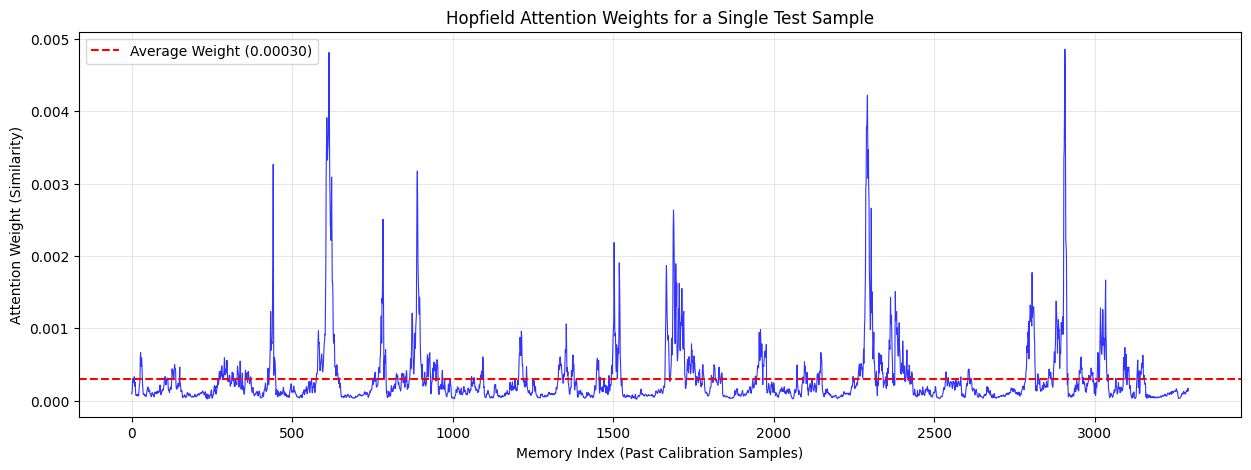

Max Weight: 0.004854
Avg Weight: 0.000304
Ratio (Peakedness): 15.98

✅ DIAGNOSIS: GOOD ATTENTION.
The model is focusing on specific past memories (the spikes).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 🩺 Diagnosing Attention Collapse ---
print("--- 🩺 Diagnosing Attention Collapse ---")

# 1. Get a single batch of test data
# We use the existing 'test_loader' and 'patch_cpt_model' from previous blocks
x_test, _ = next(iter(test_loader))
x_test = x_test.to(device)

# 2. Get the Latent State (Query)
patch_cpt_model.eval()
with torch.no_grad():
    # Pass input through backbone to get z_t
    _, z_t = patch_cpt_model.backbone(x_test)

    # Isolate target channel
    z_t_target = z_t[:, target_idx, :]

    # 3. Get the Hopfield Weights
    # Query the memory with this z_t
    weights = patch_cpt_model.hopcpt_model(z_t_target, patch_cpt_model.memory_z)

    # Move to CPU for plotting
    weights_np = weights.cpu().numpy()

# 4. Plot the weights for the first sample in the batch
plt.figure(figsize=(15, 5))
plt.plot(weights_np[0], alpha=0.8, color='blue', linewidth=0.8)
plt.title("Hopfield Attention Weights for a Single Test Sample")
plt.xlabel("Memory Index (Past Calibration Samples)")
plt.ylabel("Attention Weight (Similarity)")
plt.grid(True, alpha=0.3)

# Add a red line for the average weight (uniform)
avg_weight = weights_np[0].mean()
plt.axhline(y=avg_weight, color='red', linestyle='--', label=f'Average Weight ({avg_weight:.5f})')
plt.legend()
plt.show()

# 5. Check Distribution Statistics
max_weight = weights_np[0].max()
ratio = max_weight / avg_weight

print(f"Max Weight: {max_weight:.6f}")
print(f"Avg Weight: {avg_weight:.6f}")
print(f"Ratio (Peakedness): {ratio:.2f}")

if ratio < 2.0:
    print("\n⚠️ DIAGNOSIS: ATTENTION COLLAPSE.")
    print("The model is attending to everything equally. It has failed to learn specific regimes.")
    print("Suggested Fix: Increase the 'beta' (scaling factor) in the Hopfield module.")
else:
    print("\n✅ DIAGNOSIS: GOOD ATTENTION.")
    print("The model is focusing on specific past memories (the spikes).")